In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from xgboost import XGBClassifier
from pathlib import Path
import sys
import io

PROJECT_ROOT = Path.cwd().parents[0]
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    
from src.data.loaders import load_quotes

pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)

In [ ]:
def read_quotes_bucketed(path_pkl="data/quotes_bucketed.pkl",
                         path_csv="data/quotes_bucketed.csv"):
    pkl, csv = Path(path_pkl), Path(path_csv)

    
    if pkl.exists():
        df = pd.read_pickle(pkl)
    elif csv.exists():
        
        encs = ("utf-8", "utf-8-sig", "latin1", "cp1252")
        for enc in encs:
            try:
                df = pd.read_csv(csv, engine="python", sep=None,
                                 on_bad_lines="skip", encoding=enc,
                                 encoding_errors="replace", low_memory=False)
                break
            except Exception:
                df = None
        if df is None:  
            s = csv.read_bytes().decode("latin1", errors="replace")
            df = pd.read_csv(io.StringIO(s), engine="python",
                             sep=None, on_bad_lines="skip", low_memory=False)
        if "symbol" in df.columns:
            df = df[df["symbol"] == "AAPL"].reset_index(drop=True)
    else:
        raise FileNotFoundError("Run nb20 to write data/quotes_bucketed.{pkl|csv} first.")
    if "time" not in df.columns:
        raise KeyError("Missing 'time' column")
    if "price_mid" not in df.columns:
        if {"bid","ask"}.issubset(df.columns): df["price_mid"] = (df["bid"]+df["ask"])/2
        elif "mid$" in df.columns:             df["price_mid"] = df["mid$"]
        else: raise KeyError("Need 'price_mid' (or bid/ask or mid$)")

    df["time"] = (pd.Timestamp("1970-01-01", tz="UTC") +
                  pd.to_timedelta(df["time"].astype(float), unit="s")
                  if np.issubdtype(df["time"].dtype, np.number)
                  else pd.to_datetime(df["time"], errors="coerce", utc=True))

    df = df.sort_values("time").reset_index(drop=True)
    if "t"   not in df.columns: df.insert(0, "t", np.arange(len(df), dtype=int))
    if "vol" not in df.columns: df["vol"] = 0.0
    return df

df = read_quotes_bucketed()
df.head()

,t,time,bid,bid_size,ask,ask_size,mid,spread,bid$,ask$,mid$,spread$,mid_fwd,ret,y,spreads,imb,dmid1,dmid2,roll_vol_1s,roll_vol_5s,price_mid,vol
0,0,1970-01-01 09:30:00.004241176+00:00,5853300.0,18.0,5859400.0,200.0,5856350.0,6100.0,585.33,585.94,585.635,0.61,5856200.0,-0.000026,0,6100.0,-0.834862,NaN,NaN,NaN,NaN,5856350.0,0.0
1,1,1970-01-01 09:30:00.004260640+00:00,5853300.0,18.0,5859400.0,200.0,5856350.0,6100.0,585.33,585.94,585.635,0.61,5856200.0,-0.000026,0,6100.0,-0.834862,0.0,NaN,NaN,NaN,5856350.0,0.0
2,2,1970-01-01 09:30:00.004447484+00:00,5853300.0,18.0,5859400.0,200.0,5856350.0,6100.0,585.33,585.94,585.635,0.61,5856200.0,-0.000026,0,6100.0,-0.834862,0.0,0.0,NaN,NaN,5856350.0,0.0
3,3,1970-01-01 09:30:00.025551909+00:00,5853300.0,18.0,5859100.0,18.0,5856200.0,5800.0,585.33,585.91,585.620,0.58,5856200.0,0.000000,0,5800.0,0.000000,-150.0,-150.0,86.60254,NaN,5856200.0,0.0
4,4,1970-01-01 09:30:00.025579546+00:00,5853300.0,18.0,5859100.0,18.0,5856200.0,5800.0,585.33,585.91,585.620,0.58,5856200.0,0.000000,0,5800.0,0.000000,0.0,-150.0,75.00000,NaN,5856200.0,0.0


In [16]:
feat = df[["time","price_mid","vol"]].copy()


feat["logp"] = np.log(feat["price_mid"].clip(lower=1e-9))
feat["r1"]   = feat["logp"].diff()
feat["r2"]   = feat["r1"].shift(1)
feat["r5"]   = feat["logp"].diff(5)


feat["vol_ewm"]     = feat["r1"].ewm(span=30, adjust=False).std()
feat["vol_lag"]     = feat["vol"].shift(1).fillna(0)
feat["vol_ewm_qty"] = feat["vol"].ewm(span=30, adjust=False).mean()


sec_of_day = (feat["time"].view("int64") // 10**9) % 86400
theta = 2*np.pi*sec_of_day/86400.0
feat["tod_sin"] = np.sin(theta)
feat["tod_cos"] = np.cos(theta)


feat["r_fwd"] = feat["r1"].shift(-1)
feat = feat.dropna().reset_index(drop=True)

def sign3(x, eps=0.0):
    return 2 if x > eps else (0 if x < -eps else 1)

y = np.array([sign3(v, eps=0.0) for v in feat["r_fwd"].values], dtype=int)

feat_cols = ["r1","r2","r5","vol_ewm","vol_lag","vol_ewm_qty","tod_sin","tod_cos"]
X = feat[feat_cols].values
times = feat["time"].values

print("X:", X.shape, " | y class counts (down,flat,up):", np.bincount(y, minlength=3))


X: (400385, 8)  | y class counts (down,flat,up): [ 32523 335644  32218]


/var/folders/xx/w12875ds6blcc9p0ljq82tdw0000gn/T/ipykernel_33604/3748283542.py:15: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  sec_of_day = (feat["time"].view("int64") // 10**9) % 86400


In [17]:
n = len(feat)
split = int(n*0.80)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
t_test          = times[split:]

print(f"Train={len(X_train)}  Test={len(X_test)}  Test start={pd.to_datetime(t_test[0])}")


Train=320308  Test=80077  Test start=1970-01-01 15:16:51.775702082


In [21]:
results = []

scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_train)
X_te_s = scaler.transform(X_test)

lr = LogisticRegression(max_iter=300, multi_class="multinomial")
lr.fit(X_tr_s, y_train)
yhat_lr = lr.predict(X_te_s)
results.append(("LogisticRegression", accuracy_score(y_test, yhat_lr), f1_score(y_test, yhat_lr, average="macro")))


rf = RandomForestClassifier(n_estimators=300, max_depth=6, min_samples_leaf=20, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
yhat_rf = rf.predict(X_test)
results.append(("RandomForest", accuracy_score(y_test, yhat_rf), f1_score(y_test, yhat_rf, average="macro")))

xgb = XGBClassifier(n_estimators=2000,learning_rate=0.05,max_depth=4,subsample=0.8, colsample_bytree=0.8,min_child_weight=2,
    reg_lambda=1.0,objective="multi:softprob",n_jobs=-1,random_state=42,tree_method="hist", eval_metric="mlogloss")
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
yhat_xgb = xgb.predict(X_test)
results.append(("XGBoost", accuracy_score(y_test, yhat_xgb), f1_score(y_test, yhat_xgb, average="macro")))

res_df = pd.DataFrame(results, columns=["Model","Accuracy","f1_macro"]).sort_values("f1_macro", ascending=False)
display(res_df)


/Users/krithiktoure/Desktop/DS Project 2/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,Model,Accuracy,f1_macro
2,XGBoost,0.844912,0.320188
1,RandomForest,0.845336,0.305396
0,LogisticRegression,0.845311,0.305393


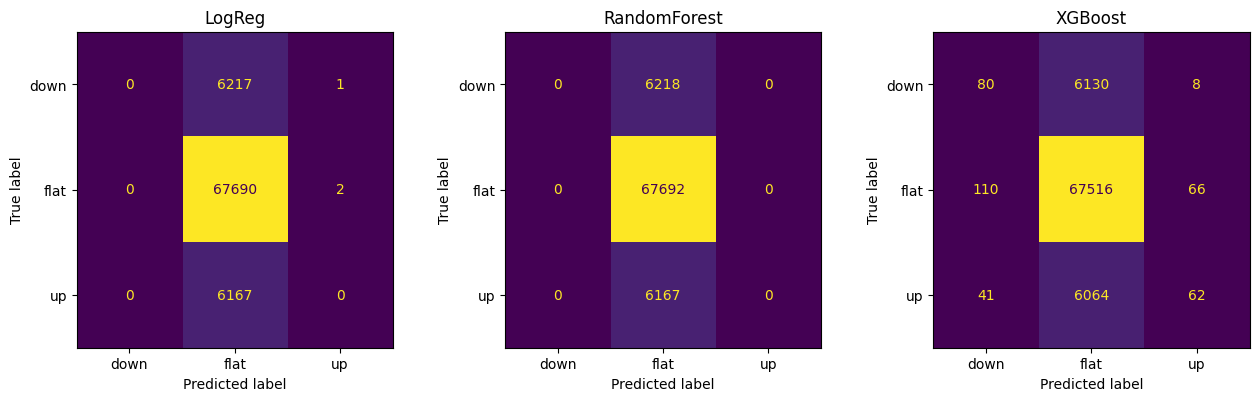

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(13,4))
for ax, (name, yhat) in zip(axes, [("LogReg", yhat_lr), ("RandomForest", yhat_rf), ("XGBoost", yhat_xgb)]):
    cm = confusion_matrix(y_test, yhat, labels=[0,1,2])
    ConfusionMatrixDisplay(cm, display_labels=["down","flat","up"]).plot(ax=ax, colorbar=False)
    ax.set_title(name)
plt.tight_layout(); plt.show()


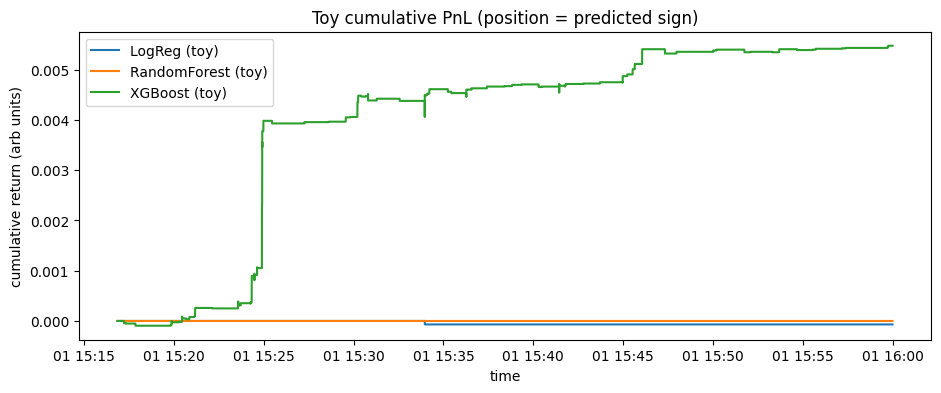

In [23]:
pos_lr  = yhat_lr  - 1
pos_rf  = yhat_rf  - 1
pos_xgb = yhat_xgb - 1

r_fwd_test = feat["r_fwd"].iloc[split:].values

cum_lr  = (pos_lr  * r_fwd_test).cumsum()
cum_rf  = (pos_rf  * r_fwd_test).cumsum()
cum_xgb = (pos_xgb * r_fwd_test).cumsum()

plt.figure(figsize=(11,4))
plt.plot(t_test, cum_lr,  label="LogReg (toy)")
plt.plot(t_test, cum_rf,  label="RandomForest (toy)")
plt.plot(t_test, cum_xgb, label="XGBoost (toy)")
plt.title("Toy cumulative PnL (position = predicted sign)")
plt.xlabel("time"); plt.ylabel("cumulative return (arb units)")
plt.legend(); plt.show()
